The following files are found:

['BF01.prn', 'BF02.prn', 'BF03.prn', 'BF04.prn', 'BF05.prn', 'BF06.prn', 'BF07.prn']




C:\Users\amartensen\AppData\Local\Temp\ipykernel_26120\461926101.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  headers = pd.read_csv(file_name, delim_whitespace=True, nrows=0).columns[1:]
C:\Users\amartensen\AppData\Local\Temp\ipykernel_26120\461926101.py:69: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  plant_power = pd.read_csv(file_name, delim_whitespace=True, header=None, skiprows=1, names=headers)
C:\Users\amartensen\AppData\Local\Temp\ipykernel_26120\461926101.py:85: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  heating_sum = integrate.simps(hourly_heating, time_stamp)
C:\Users\amartensen\AppData\Local\Temp\ipykernel_26120\461926101.py:86: DeprecationWarning: 'scipy.integrate.simps' is depreca

Name: BF01
Zone area: 583.32 m2
Total heating demand: 9578.57 kWh
Total cooling demand: 10889.43 kWh
Specific heating demand: 16.42 kWh/m2
Specific cooling demand: 18.67 kWh/m2

Name: BF02
Zone area: 516.31 m2
Total heating demand: 10608.08 kWh
Total cooling demand: 8187.43 kWh
Specific heating demand: 20.55 kWh/m2
Specific cooling demand: 15.86 kWh/m2

Name: BF03
Zone area: 555.00 m2
Total heating demand: 12753.62 kWh
Total cooling demand: 9134.65 kWh
Specific heating demand: 22.98 kWh/m2
Specific cooling demand: 16.46 kWh/m2

Name: BF04
Zone area: 658.17 m2
Total heating demand: 11593.98 kWh
Total cooling demand: 11531.58 kWh
Specific heating demand: 17.62 kWh/m2
Specific cooling demand: 17.52 kWh/m2

Name: BF05
Zone area: 463.25 m2
Total heating demand: 11283.72 kWh
Total cooling demand: 8508.26 kWh
Specific heating demand: 24.36 kWh/m2
Specific cooling demand: 18.37 kWh/m2

Name: BF06
Zone area: 674.18 m2
Total heating demand: 9012.88 kWh
Total cooling demand: 11107.66 kWh
Specific

'\n'

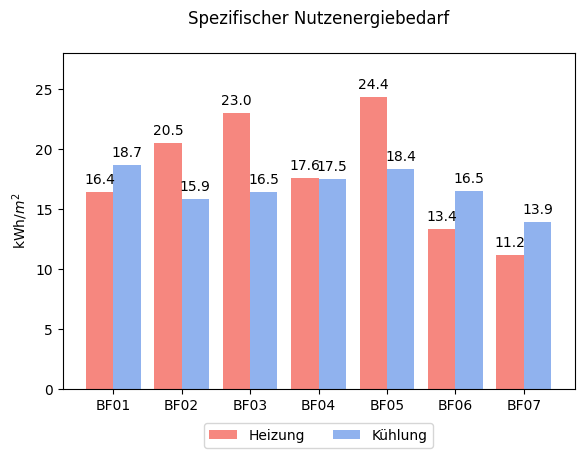

In [2]:
"""
Post-processing of PLANT_POWER.prn from IDA ICE energy simulations
The respective data titles in PLANT_POWER.prn are:
    AHU heating coil power, W
    Water based heating power to zones, W
    AHU cooling coil power, W
    Water based cooling power to zones, W
    Ideal coolers and other local units, W
    Ideal heaters and other local units, W
    Domestic hot water use, W
"""
import os
import numpy as np
import pandas as pd
import tkinter as tk
import matplotlib.pyplot as plt
from scipy import integrate

#matplotlib qt 

############################################################
# Project Information
############################################################
result_folder = "/all_results"
area_folder = "/all_zones"
zone_data_format = ".xlsx"
keyword_search = "Floor area, m2"
############################################################

############################################################
# Define Functions
############################################################
def get_all_file_names_in_directory(directory_path):
    file_names = []
    for dirpath, dirnames, filenames in os.walk(directory_path):
        file_names.extend(file for file in filenames)
    return file_names

### Class definition
class Sim_Result:
    def __init__(self, name, heating, cooling, area=0, spec_heat=0, spec_cool=0):
        self.name = name
        self.heating = heating
        self.cooling = cooling
        self.area = area
        self.spec_heat = spec_heat
        self.spec_cool = spec_cool
############################################################

############################################################
# Reading & Processing
############################################################
working_dir = os.path.abspath('')
res_path = working_dir+result_folder
area_path = working_dir+area_folder
all_file_names = get_all_file_names_in_directory(res_path)

print("The following files are found:\n")
print(all_file_names)
print("\n")

### Initialise building lists 
building_list = []

os.chdir(res_path)
for file_name in all_file_names:
    # Read the PRN file and create a DataFrame, discarding the first column starting with a hashtag
    headers = pd.read_csv(file_name, delim_whitespace=True, nrows=0).columns[1:]
    plant_power = pd.read_csv(file_name, delim_whitespace=True, header=None, skiprows=1, names=headers)

### Display the first few rows of the DataFrame to verify it was loaded correctly
#     print(plant_power.head())
#     print(headers)

    # # All units in Watt
    time_stamp = plant_power['time']
    AHU_heating = plant_power["boil_q_1"]
    Water_heating = plant_power["boil_q_2"]
    AHU_cooling = plant_power["chil_q1"]
    Water_cooling = plant_power["chil_q2"]
    Ideal_coolers = plant_power["loccool"]
    Ideal_heaters = plant_power["locheat"]
    hourly_heating = AHU_heating+Water_heating+Ideal_heaters
    hourly_cooling = AHU_cooling+Water_cooling+Ideal_coolers
    heating_sum = integrate.simps(hourly_heating, time_stamp)
    cooling_sum = integrate.simps(hourly_cooling, time_stamp)
    # Use energy demand in kWh
    building = Sim_Result(name = file_name.split(".")[0], heating = heating_sum/1000, cooling = cooling_sum/1000)
    building_list.append(building)

### Read zone areas and calculate specific heating & cooling demand    
os.chdir(area_path)
for building in building_list:
    area_file = building.name + zone_data_format
    zone_data = pd.read_excel(area_file, index_col=None, skiprows=1, header=None)  
    column_count = np.where(zone_data == keyword_search)[1][0]
    row_count = np.where(zone_data[:][column_count].isna())[0][0]
    zone_area = zone_data[1:row_count][column_count]
    # total area of all simulated zones
    all_zone_area = zone_area.astype(float).sum()
    building.area = all_zone_area
    building.spec_heat = building.heating/building.area  # in kWh/m2
    building.spec_cool = building.cooling/building.area  # in kWh/m2

os.chdir(working_dir)
############################################################

############################################################
# Print & Plot -- WIP
############################################################
### Plot settings
heating_rgb = np.divide([246,135,127],255)
cooling_rgb = np.divide([144,178,238],255)

bar_width = 0.4
label_size = 10
############################################################
### Display all building results. Can be exported to file
# for building in building_list:
#     attrs = vars(building)
#     print('\n'.join("%s: %.2f" % item for item in attrs.items()))

for building in building_list:
    print('Name: ' + building.name)
    print('Zone area: %.2f m2' % building.area)
    print('Total heating demand: %.2f kWh' % building.heating)
    print('Total cooling demand: %.2f kWh' % building.cooling)    
    print('Specific heating demand: %.2f kWh/m2' % building.spec_heat)
    print('Specific cooling demand: %.2f kWh/m2\n' % building.spec_cool)    

### Initialisation
names_all = []
spec_heat_all = []
spec_cool_all = []
for building in building_list:
    names_all.append(building.name.split(".")[0])
    spec_heat_all.append(building.spec_heat)
    spec_cool_all.append(building.spec_cool)
x = np.arange(len(names_all))

### Plot specific heating & cooling demand
fig1, ax1 = plt.subplots()
ax1.bar(x-0.2, spec_heat_all, bar_width, color = heating_rgb, label="Heizung") 
ax1.bar(x+0.2, spec_cool_all, bar_width, color = cooling_rgb, label="Kühlung") 

### Plot settings
ax1.set_ylabel('kWh/$m^2$')
ax1.set_title('Spezifischer Nutzenergiebedarf\n', loc='center')
ax1.set_xticks(x,names_all)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncols=2)
ax1.set_position([0.1,0.15,0.8,0.7])
ax1.set_ylim(0, max(max(spec_heat_all,spec_cool_all))*1.5)
for rect in ax1.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()    
    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values    
    label_x = x + width / 2
    label_y = y + height + 1   
    # only plot labels greater than given width
    if height > 2:
        ax1.text(label_x, label_y, label_text, ha='center', va='center', fontsize=label_size)
    elif 0.1< height <= 2:
        ax1.text(label_x, label_y, label_text, ha='center', va='center', fontsize=label_size)

'''
'''

BF03.prn is selected.


C:\Users\amartensen\AppData\Local\Temp\ipykernel_26120\3471312845.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  plant_power = pd.read_csv(the_chosen_one, delim_whitespace=True, header=None, skiprows=1, names=headers)
C:\Users\amartensen\AppData\Local\Temp\ipykernel_26120\3471312845.py:71: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  dyn_heating_thismon = integrate.simps(hrly_dyn_heating[start_time_stamp:end_time_stamp],
C:\Users\amartensen\AppData\Local\Temp\ipykernel_26120\3471312845.py:73: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sta_heating_thismon = integrate.simps(hrly_sta_heating[start_time_stamp:end_time_stamp],
C:\Users\amartensen\AppData\Local\Temp\ipykernel_26120\3471312845.py:75: Deprecation

TypeError: unsupported operand type(s) for /: 'list' and 'int'

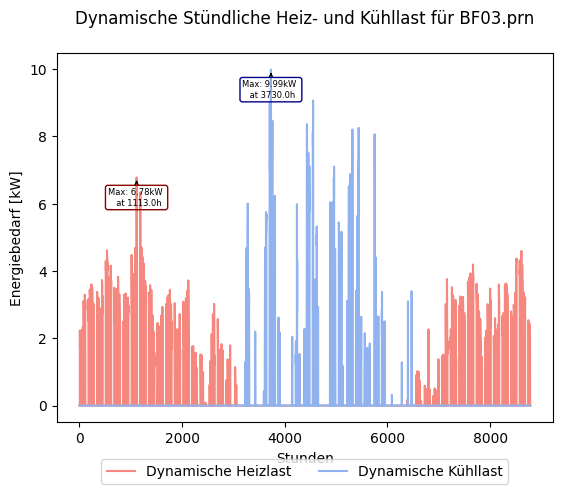

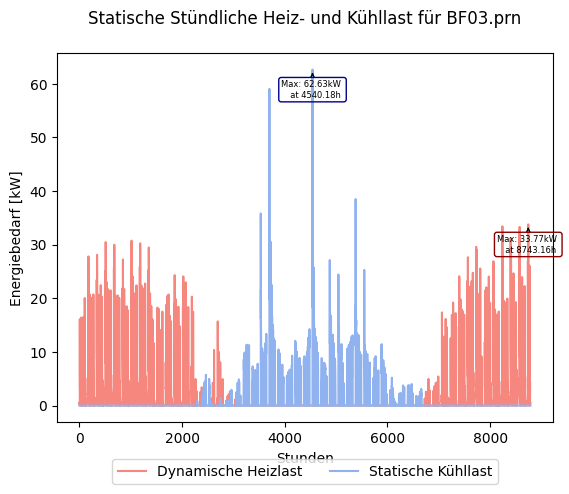

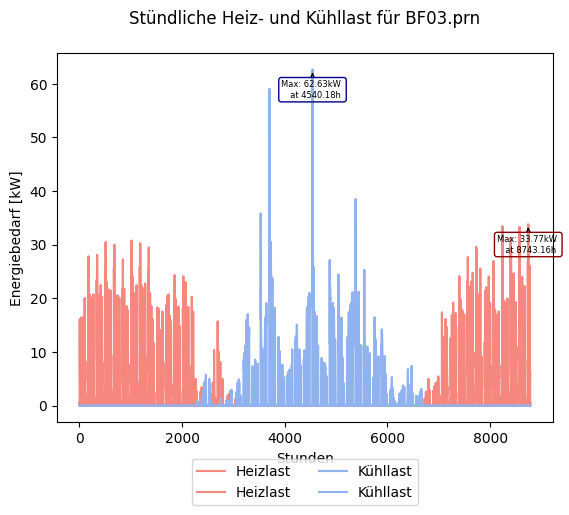

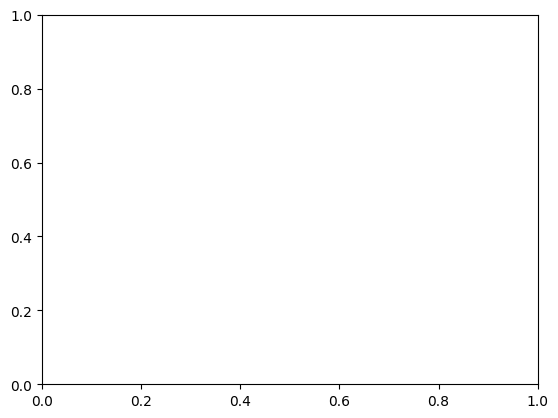

In [3]:
'''
'''

### Initialisation:
baseload_pctl_h, baseload_watt_h = 0, 0
filter_min = 0.1 # only plot values above this Watt
### Definition
# baseload_pctl_h = 98 # baseload percentile of heating (h) loads
baseload_watt_h = 3.5 * 10**3 # alternatively in W

# Monthly results calculation
mth_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
days_in_mons = [31,29,31,30,31,30,31,31,30,31,30,31]
hrs_in_mons = np.multiply(days_in_mons,24)
days_cumu = np.cumsum(days_in_mons)
days_cumubefore = np.concatenate((np.zeros(1), days_cumu[0:-1])).astype(int)
hrs_cumubefore = np.concatenate((days_cumubefore*24, [sum(days_in_mons)*24])).astype(int)

# A popup window to select which building to display results
def select_building(event):
    global the_chosen_one
    the_chosen_one = all_file_names[building_selection.curselection()[0]]
    print(the_chosen_one + ' is selected.')
    root.destroy()
    return the_chosen_one

root = tk.Tk()
label = tk.Label(root, text='Single click to select one file for display:')
label.grid()
        
items = all_file_names
var = tk.StringVar()
var.set(items)      
        
building_selection = tk.Listbox(root, listvariable=var, selectmode='extended')
building_selection.grid()
building_selection.bind('<<ListboxSelect>>', select_building)

root.mainloop() # end of popup

# Read the selected building file
os.chdir(res_path)
plant_power = pd.read_csv(the_chosen_one, delim_whitespace=True, header=None, skiprows=1, names=headers)
# # All units in Watt
time_stamp = plant_power['time']
AHU_heating = plant_power["boil_q_1"]
Water_heating = plant_power["boil_q_2"]
AHU_cooling = plant_power["chil_q1"]
Water_cooling = plant_power["chil_q2"]
Ideal_coolers = plant_power["loccool"]
Ideal_heaters = plant_power["locheat"]
hourly_heating = AHU_heating+Water_heating+Ideal_heaters
hourly_cooling = AHU_cooling+Water_cooling+Ideal_coolers

## Definition of static and dynamic heating & cooling
hrly_dyn_heating = AHU_heating
hrly_sta_heating = Water_heating+Ideal_heaters
hrly_dyn_cooling = AHU_cooling
hrly_sta_cooling = Water_cooling+Ideal_coolers

# Calculate Monthly energy demand
dyn_heating_monthly = []
sta_heating_monthly = []
dyn_cooling_monthly = []
sta_cooling_monthly = []

for i in range(len(hrs_cumubefore)-1):
    start_time_stamp = np.argmin(np.abs(time_stamp - hrs_cumubefore[i]))
    end_time_stamp = np.argmin(np.abs(time_stamp - hrs_cumubefore[i+1]))
#     print(time_stamp[start_time_stamp], time_stamp[end_time_stamp])
    dyn_heating_thismon = integrate.simps(hrly_dyn_heating[start_time_stamp:end_time_stamp], 
                                      time_stamp[start_time_stamp:end_time_stamp])
    sta_heating_thismon = integrate.simps(hrly_sta_heating[start_time_stamp:end_time_stamp], 
                                      time_stamp[start_time_stamp:end_time_stamp])    
    dyn_cooling_thismon = integrate.simps(hrly_dyn_cooling[start_time_stamp:end_time_stamp], 
                                      time_stamp[start_time_stamp:end_time_stamp])
    sta_cooling_thismon = integrate.simps(hrly_sta_cooling[start_time_stamp:end_time_stamp], 
                                      time_stamp[start_time_stamp:end_time_stamp])    
    dyn_heating_monthly.append(dyn_heating_thismon) # Wh
    sta_heating_monthly.append(sta_heating_thismon) # Wh
    dyn_cooling_monthly.append(dyn_cooling_thismon) # Wh
    sta_cooling_monthly.append(sta_cooling_thismon) # Wh




# annotation font size
ann_fon_size=6


### Plot hourly curves Dynamic ###
# Dynamische Heizlast
fig2_dyn, ax2_dyn = plt.subplots()
max_dyn_heating = max(hrly_dyn_heating/1000)
max_dyn_heating_time = time_stamp[hrly_dyn_heating.argmax()]
ax2_dyn.plot(time_stamp, hrly_dyn_heating/1000, color = heating_rgb ,label="Dynamische Heizlast")  
ax2_dyn.annotate(f"Max: {round(max_dyn_heating,2)}kW \n  at {round(max_dyn_heating_time,2)}h",fontsize=ann_fon_size ,xy=(max_dyn_heating_time,max_dyn_heating),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="darkred"),
            xytext=(0, -20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

# Dynamische Kühllast
max_dyn_cooling = max(hrly_dyn_cooling/1000)
max_dyn_cooling_time = time_stamp[hrly_dyn_cooling.argmax()]
ax2_dyn.plot(time_stamp, hrly_dyn_cooling/1000, color=cooling_rgb, label="Dynamische Kühllast")
ax2_dyn.annotate(f"Max: {round(max_dyn_cooling,2)}kW \n at {round(max_dyn_cooling_time,2)}h",fontsize=ann_fon_size ,xy=(max_dyn_cooling_time,max_dyn_cooling),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="darkblue"),
            xytext=(0, -20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))


ax2_dyn.set_xticks(np.arange(0, 9000, 2000))
ax2_dyn.set_ylabel('Energiebedarf [kW]') 
ax2_dyn.set_xlabel('Stunden') 
ax2_dyn.set_title('Dynamische Stündliche Heiz- und Kühllast für %s\n' % the_chosen_one)   
ax2_dyn.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncols=2)

### Plot hourly curves static ###
# Statische Heizlast
fig2_stat, ax2_stat = plt.subplots()
max_stat_heating = max(hrly_sta_heating/1000)
max_stat_heating_time = time_stamp[hrly_sta_heating.argmax()]
ax2_stat.plot(time_stamp, hrly_sta_heating/1000, color = heating_rgb ,label="Dynamische Heizlast")  
ax2_stat.annotate(f"Max: {round(max_stat_heating,2)}kW \n  at {round(max_stat_heating_time,2)}h",fontsize=ann_fon_size ,xy=(max_stat_heating_time,max_stat_heating),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="darkred"),
            xytext=(0, -20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

# Statische Kühllast
max_stat_cooling = max(hrly_sta_cooling/1000)
max_stat_cooling_time = time_stamp[hrly_sta_cooling.argmax()]
ax2_stat.plot(time_stamp, hrly_sta_cooling/1000, color=cooling_rgb, label="Statische Kühllast")
ax2_stat.annotate(f"Max: {round(max_stat_cooling,2)}kW \n  at {round(max_stat_cooling_time,2)}h",fontsize=ann_fon_size ,xy=(max_stat_cooling_time,max_stat_cooling),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="darkblue"),
            xytext=(0, -20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax2_stat.set_xticks(np.arange(0, 9000, 2000))
ax2_stat.set_ylabel('Energiebedarf [kW]') 
ax2_stat.set_xlabel('Stunden') 
ax2_stat.set_title('Statische Stündliche Heiz- und Kühllast für %s\n' % the_chosen_one)   
ax2_stat.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncols=2)

#### Plot hourly curves###
# stat + dyn Heizlast
fig2, ax2 = plt.subplots()
ax2.plot(time_stamp, hourly_heating/1000, color = heating_rgb, label="Heizlast")  
max_heating = max(hourly_heating/1000)
max_heating_time = time_stamp[hourly_heating.argmax()]
ax2.plot(time_stamp, hourly_heating/1000, color = heating_rgb ,label="Heizlast")  
ax2.annotate(f"Max: {round(max_heating,2)}kW \n  at {round(max_heating_time,2)}h",fontsize=ann_fon_size ,xy=(max_heating_time,max_heating),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="darkred"),
            xytext=(0, -20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))


# stat + dyn Kühllast
ax2.plot(time_stamp, hourly_cooling/1000, color = cooling_rgb, label="Kühllast") 
max_cooling = max(hourly_cooling/1000)
max_cooling_time = time_stamp[hourly_cooling.argmax()]
ax2.plot(time_stamp, hourly_cooling/1000, color = cooling_rgb ,label="Kühllast")  
ax2.annotate(f"Max: {round(max_cooling,2)}kW \n  at {round(max_cooling_time,2)}h",fontsize=ann_fon_size ,xy=(max_cooling_time,max_cooling),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="darkblue"),
            xytext=(0, -20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax2.set_xticks(np.arange(0, 9000, 2000))
ax2.set_ylabel('Energiebedarf [kW]') 
ax2.set_xlabel('Stunden') 
ax2.set_title('Stündliche Heiz- und Kühllast für %s\n' % the_chosen_one)   
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncols=2)


### Plot Monthly curves Dynamic ###
# Dynamische Heizlast
fig2_dyn_month, ax2_dyn_month = plt.subplots()
max_dyn_heating_month = max(dyn_heating_monthly/1000)
max_dyn_heating_time_month = time_stamp[dyn_heating_monthly.argmax()]
ax2_dyn_month.plot(time_stamp, hrly_dyn_heating/1000, color = heating_rgb ,label="Dynamische Heizlast")  
ax2_dyn_month.annotate(f"Max: {round(max_dyn_heating,2)}kW \n  at {round(max_dyn_heating_time_month,2)}h",fontsize=ann_fon_size ,xy=(max_dyn_heating_time_month,max_dyn_heating_month),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="darkred"),
            xytext=(0, -20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

# # Dynamische Kühllast
# max_dyn_cooling = max(hrly_dyn_cooling/1000)
# max_dyn_cooling_time = time_stamp[hrly_dyn_cooling.argmax()]
# ax2_dyn.plot(time_stamp, hrly_dyn_cooling/1000, color=cooling_rgb, label="Dynamische Kühllast")
# ax2_dyn.annotate(f"Max: {round(max_dyn_cooling,2)}kW \n at {round(max_dyn_cooling_time,2)}h",fontsize=ann_fon_size ,xy=(max_dyn_cooling_time,max_dyn_cooling),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="darkblue"),
#             xytext=(0, -20), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))


ax2_dyn.set_xticks(np.arange(0, 9000, 2000))
ax2_dyn.set_ylabel('Energiebedarf [kW]') 
ax2_dyn.set_xlabel('Stunden') 
ax2_dyn.set_title('Dynamische Monatliche Heiz- und Kühllast für %s\n' % the_chosen_one)   
ax2_dyn.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncols=2)

# Jahresdauerlinien/Load Duration Curve
sorted_heating = -np.sort(-hourly_heating)
sorted_cooling = -np.sort(-hourly_cooling)
filtered_heating = sorted_heating[np.where(sorted_heating>filter_min)[0]]
filtered_cooling = sorted_cooling[np.where(sorted_cooling>filter_min)[0]]

fig3, (ax3, ax4) = plt.subplots(2, 1)
ax3.plot(time_stamp, sorted_heating/1000, color = heating_rgb, label="Heizlast")  
ax4.plot(time_stamp, sorted_cooling/1000, color = cooling_rgb, label="Kühllast") 
ax3.set_xlim(0, 9000)
ax4.set_xlim(0, 9000)
ax3.set_title('Jahresdauerlinien für %s\n' % the_chosen_one) 

if baseload_watt_h:
    print('Baseload given in watt')
    baseload_where_h = time_stamp[np.where(
        sorted_heating == min(sorted_heating, key=lambda x:abs(x-baseload_watt_h)))[0][0]]     
elif not baseload_watt_h and baseload_pctl_h:
    print('Baseload given in percentile')
    baseload_watt_h = np.percentile(sorted_heating, baseload_pctl_h)
    baseload_where_h = np.percentile(time_stamp, 100-baseload_pctl_h)    

if baseload_watt_h:
    ax3.axhline(baseload_watt_h/1000, 0, baseload_where_h/time_stamp[len(time_stamp)-1], 
                color='r', linestyle='--', label='Horizontal Line')
    ax3.fill_between(time_stamp, baseload_watt_h/1000, sorted_heating/1000, 
                     where=(baseload_watt_h < sorted_heating), 
                     color=heating_rgb, alpha=1, interpolate=True)
    ax3.fill_between(time_stamp, np.fmin(sorted_heating,baseload_watt_h)/1000, 
                     color=heating_rgb, alpha=0.5,interpolate=True)


# Cut load hours under filter_min (shorten the tail of the plot)
# fig4, (ax5, ax6) = plt.subplots(2, 1)
# ax5.plot(time_stamp[np.where(sorted_heating>filter_min)[0]], 
#          filtered_heating/1000, color = heating_rgb, label="Heizlast")  
# ax6.plot(time_stamp[np.where(sorted_cooling>filter_min)[0]], 
#          filtered_cooling/1000, color = cooling_rgb, label="Kühllast") 
# ax5.set_xlim(0, int(time_stamp[len(np.where(sorted_cooling>filter_min)[0])]))
# ax6.set_xlim(0, int(time_stamp[len(np.where(sorted_cooling>filter_min)[0])]))

##Definition static and dynamic heating & cooling
# Monthly plot: separation of dynamic & static

plt.show()

'''
'''

C:\Users\amartensen\AppData\Local\Temp\ipykernel_29828\3352203688.py:18: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  heating_thismon = integrate.simps(hourly_heating[start_time_stamp:end_time_stamp],
C:\Users\amartensen\AppData\Local\Temp\ipykernel_29828\3352203688.py:20: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  cooling_thismon = integrate.simps(hourly_cooling[start_time_stamp:end_time_stamp],
C:\Users\amartensen\AppData\Local\Temp\ipykernel_29828\3352203688.py:66: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  dyn_heating_thismon = integrate.simps(hrly_dyn_heating[start_time_stamp:end_time_stamp],
C:\Users\amartensen\AppData\Local\Temp\ipykernel_29828\3352203688.py:68: DeprecationWarning: 'scipy.integrate.simps' is d

'\n'

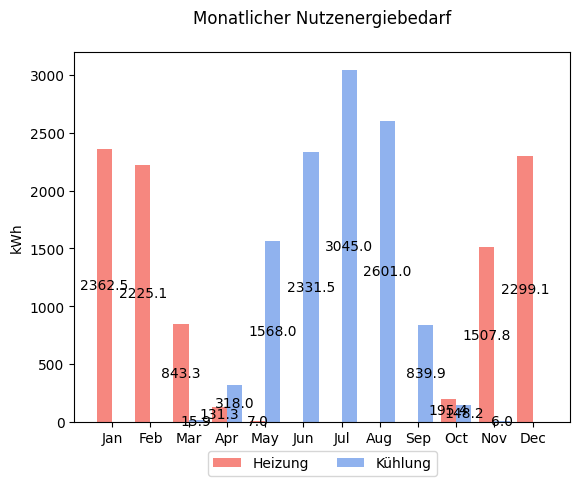

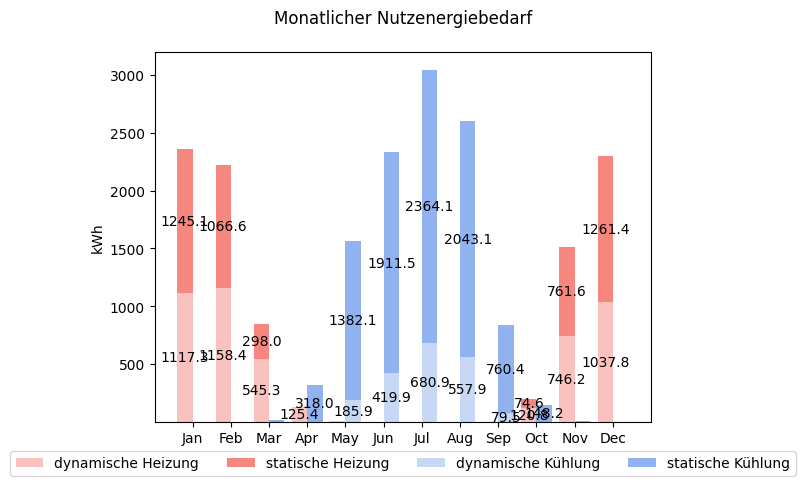

In [ ]:
'''
'''
# Monthly results calculation
mth_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
days_in_mons = [31,29,31,30,31,30,31,31,30,31,30,31]
hrs_in_mons = np.multiply(days_in_mons,24)
days_cumu = np.cumsum(days_in_mons)
days_cumubefore = np.concatenate((np.zeros(1), days_cumu[0:-1])).astype(int)
hrs_cumubefore = np.concatenate((days_cumubefore*24, [sum(days_in_mons)*24])).astype(int)

# Calculate Monthly energy demand
heating_monthly = []
cooling_monthly = []
for i in range(len(hrs_cumubefore)-1):
    start_time_stamp = np.argmin(np.abs(time_stamp - hrs_cumubefore[i]))
    end_time_stamp = np.argmin(np.abs(time_stamp - hrs_cumubefore[i+1]))
#     print(time_stamp[start_time_stamp], time_stamp[end_time_stamp])
    heating_thismon = integrate.simps(hourly_heating[start_time_stamp:end_time_stamp], 
                                      time_stamp[start_time_stamp:end_time_stamp])
    cooling_thismon = integrate.simps(hourly_cooling[start_time_stamp:end_time_stamp], 
                                      time_stamp[start_time_stamp:end_time_stamp])
    heating_monthly.append(heating_thismon) # Wh
    cooling_monthly.append(cooling_thismon) # Wh

### Plot monthly heating & cooling demand in kWh
fig5, ax7 = plt.subplots()
ax7.bar(np.arange(len(hrs_cumubefore)-1)-0.2, np.divide(heating_monthly,1000), bar_width, color = heating_rgb, label="Heizung") 
ax7.bar(np.arange(len(hrs_cumubefore)-1)+0.2, np.divide(cooling_monthly,1000), bar_width, color = cooling_rgb, label="Kühlung") 
ax7.set_xticks(np.arange(len(hrs_cumubefore)-1),mth_labels)
for rect in ax7.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()    
    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values    
    label_x = x + width/2
    label_y = y + height/2   
    # only plot labels greater than given width
    if height > 2:
        ax7.text(label_x, label_y, label_text, ha='center', va='center', fontsize=label_size)
    elif 0.1< height <= 2:
        ax7.text(label_x, label_y, label_text, ha='center', va='center', fontsize=label_size)
ax7.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), ncols=2)
ax7.set_ylabel('kWh')
ax7.set_title('Monatlicher Nutzenergiebedarf\n', loc='center')   
        
##Definition static and dynamic heating & cooling
# Monthly plot: separation of dynamic & static
hrly_dyn_heating = AHU_heating
hrly_sta_heating = Water_heating+Ideal_heaters
hrly_dyn_cooling = AHU_cooling
hrly_sta_cooling = Water_cooling+Ideal_coolers

# Calculate Monthly energy demand
dyn_heating_monthly = []
sta_heating_monthly = []
dyn_cooling_monthly = []
sta_cooling_monthly = []

for i in range(len(hrs_cumubefore)-1):
    start_time_stamp = np.argmin(np.abs(time_stamp - hrs_cumubefore[i]))
    end_time_stamp = np.argmin(np.abs(time_stamp - hrs_cumubefore[i+1]))
#     print(time_stamp[start_time_stamp], time_stamp[end_time_stamp])
    dyn_heating_thismon = integrate.simps(hrly_dyn_heating[start_time_stamp:end_time_stamp], 
                                      time_stamp[start_time_stamp:end_time_stamp])
    sta_heating_thismon = integrate.simps(hrly_sta_heating[start_time_stamp:end_time_stamp], 
                                      time_stamp[start_time_stamp:end_time_stamp])    
    dyn_cooling_thismon = integrate.simps(hrly_dyn_cooling[start_time_stamp:end_time_stamp], 
                                      time_stamp[start_time_stamp:end_time_stamp])
    sta_cooling_thismon = integrate.simps(hrly_sta_cooling[start_time_stamp:end_time_stamp], 
                                      time_stamp[start_time_stamp:end_time_stamp])    
    dyn_heating_monthly.append(dyn_heating_thismon) # Wh
    sta_heating_monthly.append(sta_heating_thismon) # Wh
    dyn_cooling_monthly.append(dyn_cooling_thismon) # Wh
    sta_cooling_monthly.append(sta_cooling_thismon) # Wh

### Plot monthly heating & cooling demand in kWh
fig6, ax8 = plt.subplots()
ax8.bar(np.arange(len(hrs_cumubefore)-1)-0.2, np.divide(dyn_heating_monthly,1000), bar_width,
        bottom = 0, color = heating_rgb, alpha = 0.5, label="dynamische Heizung") 
ax8.bar(np.arange(len(hrs_cumubefore)-1)-0.2, np.divide(sta_heating_monthly,1000), bar_width, 
        bottom = np.divide(dyn_heating_monthly,1000), color = heating_rgb, label="statische Heizung") 
ax8.bar(np.arange(len(hrs_cumubefore)-1)+0.2, np.divide(dyn_cooling_monthly,1000), bar_width,
        bottom = 0, color = cooling_rgb, alpha = 0.5, label="dynamische Kühlung") 
ax8.bar(np.arange(len(hrs_cumubefore)-1)+0.2, np.divide(sta_cooling_monthly,1000), bar_width, 
        bottom = np.divide(dyn_cooling_monthly,1000), color = cooling_rgb, label="statische Kühlung") 
ax8.set_xticks(np.arange(len(hrs_cumubefore)-1),mth_labels)
for rect in ax8.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()    
    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values    
    label_x = x + width / 2
    label_y = y + height / 2   
    # only plot labels greater than given width
    if height > 30:
        ax8.text(label_x, label_y, label_text, ha='center', va='center', fontsize=label_size)
#     elif 0.1< height <= 2:
#         ax8.text(label_x, label_y, label_text, ha='center', va='center', fontsize=label_size)
ax8.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), ncols=4)
ax8.set_ylabel('kWh')
ax8.set_title('Monatlicher Nutzenergiebedarf\n', loc='center')        

'''
'''

In [ ]:
# TODOS
# sizing of plots
# monthly curves in specific values
# max value of dyn/sta heating & cooling marked on hourly plot, also max on sum
# comparison of buildings/variations also separated dyn/sta

# dry bulb temperature ambient - read from weather file, most likely epw. sometimes dwd

# upscaling with GFA & factors - instead of excel


# input parameters
# internal gains & schedules


# electricity demand
# standard library of measures

In [ ]:
# WIP!!!!
# cumulative area peak & base load 


# heating_sum = integrate.simps(hourly_heating, time_stamp)
# cooling_sum = integrate.simps(hourly_cooling, time_stamp)
# ax3.fill_between(time_stamp, baseload_watt_h/1000, sorted_heating/1000, 
#                  where=(baseload_watt_h < sorted_heating), 
#                  color=heating_rgb, alpha=1, interpolate=True)
# ax3.fill_between(time_stamp, np.fmin(sorted_heating,baseload_watt_h)/1000, 
#                  color=heating_rgb, alpha=0.5,interpolate=True)